In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import backend as K
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Custom preprocessing function for amplitude shift and additive noise
def rf_augment(image):
    # Amplitude shift (scale and offset)
    scale = np.random.uniform(0.98, 1.02)
    offset = np.random.uniform(-0.02, 0.02)
    image = image * scale + offset

    # Additive Gaussian noise (low-level)
    noise = np.random.normal(loc=0.0, scale=0.01, size=image.shape)
    image = image + noise

    return image

# Create the augmented data generator
data_gen = ImageDataGenerator(
    width_shift_range=0.02,     # Time shift
    height_shift_range=0.02,    # Frequency shift
    fill_mode='nearest',
    preprocessing_function=rf_augment
)

# Paths
TRAIN_DIR = './Train'
TEST_DIR = './Test'
LABELS_FILE = './label_train.csv'

Training data shape: (1491, 72, 48)


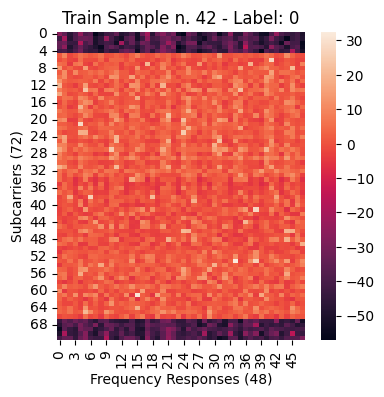

In [17]:
# Load labels
labels_df = pd.read_csv(LABELS_FILE)

# Load training data
def load_data(directory, labels_df):
    X = []
    y = []
    for idx, row in labels_df.iterrows():
        file_name = f"{row['ID']}.npy"
        file_path = os.path.join(directory, file_name)
        sample = np.load(file_path)
        X.append(sample)
        y.append(row['target'])
    return np.array(X), np.array(y)

X, y = load_data(TRAIN_DIR, labels_df)

print(f"Training data shape: {X.shape}")

i = 42
plt.figure(figsize=(4, 4))
sns.heatmap(X[i], cmap='rocket')
plt.title(f"Train Sample n. {i} - Label: {int(y[i])}")
plt.xlabel("Frequency Responses (48)")
plt.ylabel("Subcarriers (72)")
plt.savefig("./export/input_data.svg", format='svg')
plt.show()


In [ ]:
# Normalize data
X = (X - np.mean(X)) / np.std(X)

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Expand dimensions if needed (add channel dimension)
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)

# Automatically calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

In [19]:
# Build the CNN model
def build_model():
    model = keras.Sequential([
        layers.Input(shape=(72, 48, 1)),

        layers.Conv2D(32, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(256, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),

        layers.Conv2D(512, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.GlobalAveragePooling2D(),  # replaces flatten

        layers.Dense(64, activation='relu'),
        layers.Dropout(0.4),

        layers.Dense(3, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(0.00025),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 72, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 72, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 72, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 36, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 36, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 36, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 36, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 18, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 18, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 18, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 18, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 9, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 9, 6, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 9, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 3, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 4, 3, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 4, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        32,83

 Total params: 1,604,995 (6.12 MB)

 Trainable params: 1,603,011 (6.12 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [20]:
# Train the model
history = model.fit(
    X_train, y_train, 
    batch_size=4,
    validation_data=(X_val, y_val),
    epochs=80,
    class_weight=class_weights_dict,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=15, monitor='val_loss', verbose=1, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-8)
    ]
)

Epoch 1/80
298/298 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.6546 - loss: 0.6721 - val_accuracy: 0.0936 - val_loss: 8.0895 - learning_rate: 2.5000e-04
Epoch 2/80
298/298 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9093 - loss: 0.3706 - val_accuracy: 0.0936 - val_loss: 2.5327 - learning_rate: 2.5000e-04
Epoch 3/80
298/298 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9115 - loss: 0.3064 - val_accuracy: 1.0000 - val_loss: 0.0307 - learning_rate: 2.5000e-04
Epoch 4/80
298/298 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9581 - loss: 0.2637 - val_accuracy: 0.8829 - val_loss: 0.2978 - learning_rate: 2.5000e-04
Epoch 5/80
298/298 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9759 - loss: 0.1334 - val_accuracy: 0.9933 - val_loss: 0.0091 - learning_rate: 2.5000e-04
Epoch 6/80
298/298 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - accuracy: 0.9587 - loss: 0.2705 - val_accuracy: 0.6154 - val_loss: 0.7895 - learning_rate: 2.5000e-04
Epoch 7/80
298/298 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/ste

In [21]:
# Load test data
def load_test_data(directory):
    files = sorted(os.listdir(directory), key=lambda x: int(x.split('.')[0]))
    X_test = []
    file_names = []
    for file in files:
        file_path = os.path.join(directory, file)
        sample = np.load(file_path)
        X_test.append(sample)
        file_names.append(file.split('.')[0])
    return np.array(X_test), file_names

X_test, test_file_names = load_test_data(TEST_DIR)
X_test = (X_test - np.mean(X_test)) / np.std(X_test)
X_test = np.expand_dims(X_test, axis=-1)

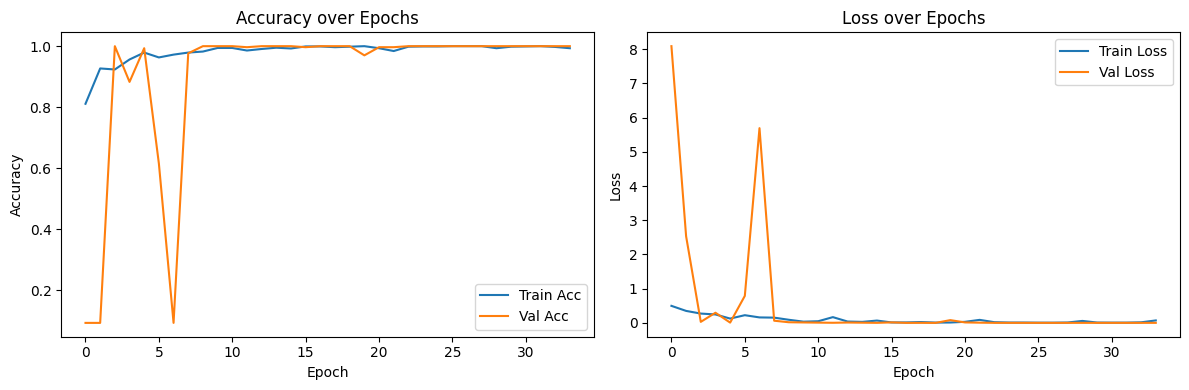

In [35]:
# import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
# 1. Accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

# 2. Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.tight_layout()
plt.savefig("./export/epoch_plot.svg", format='svg')
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
10/10 - 0s - 45ms/step - accuracy: 1.0000 - loss: 8.1674e-04
Validation Accuracy: 1.0000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


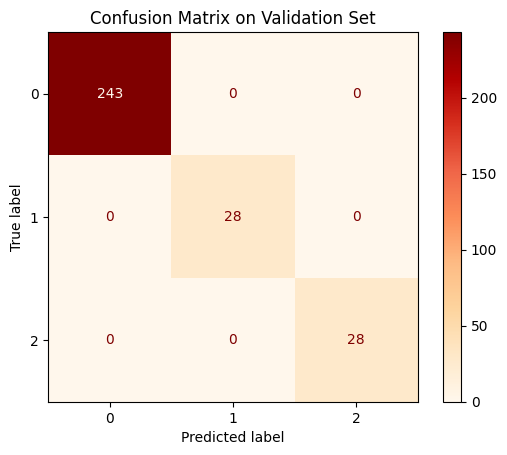

In [34]:
# Predict
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

# Evaluate model on validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=2)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Predict on validation set
y_val_pred = model.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_val, y_val_pred_classes)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
disp.plot(cmap=plt.cm.OrRd)
plt.title('Confusion Matrix on Validation Set')
plt.savefig("./export/confusion.svg", format='svg')
plt.show()

In [18]:
# Save for Kaggle
submission = pd.DataFrame({
    'ID': test_file_names,
    'target': predicted_labels
})
submission.to_csv('submission.csv', index=False)

print("Submission file saved as submission.csv")

Submission file saved as submission.csv
